## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-04-29 11:45:25.121 | INFO     |  Running on cpu


In [3]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'Test2'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-04-29 11:45:28.238 | INFO     |  Loading dataset(s): 
2025-04-29 11:45:28.239 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/Test2/demos/metadata.json
2025-04-29 11:45:28.240 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-04-29 11:45:28.240 | INFO     |    Extracted tsdf object labels []
2025-04-29 11:45:28.240 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.flo

In [4]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([34, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([34]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([34, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([34, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([34, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([34, 3, 256, 256]), device=cpu, dtype=to

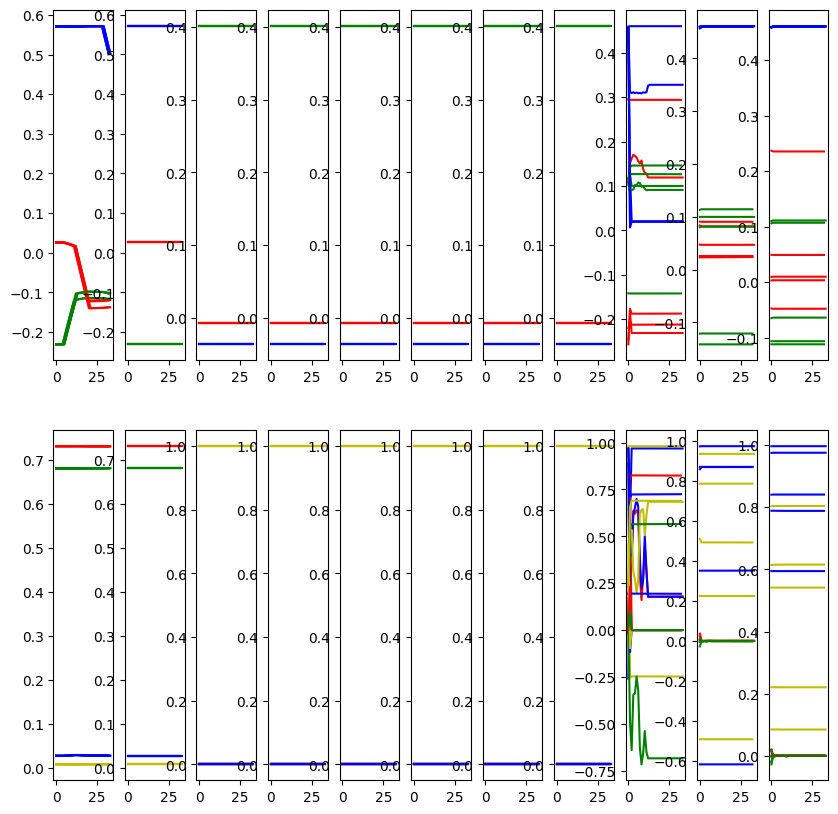

In [6]:
demos.debug_trajs()

In [7]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=1,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,  # Does prune segmentation
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.01,
    components_prop_to_len=True,
    #min_n_components=2,
    min_end_distance=2
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [8]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-04-29 11:45:32.049 | INFO     |  Fitting AutoTPGMM
2025-04-29 11:45:32.050 | INFO     |  Performing fitting actions: [INIT]
2025-04-29 11:45:32.050 | INFO     |  Segmenting trajectories


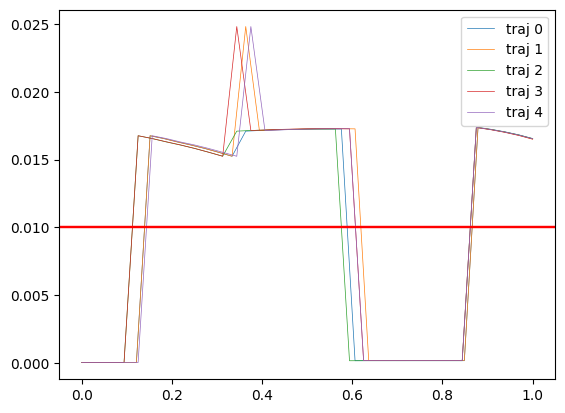

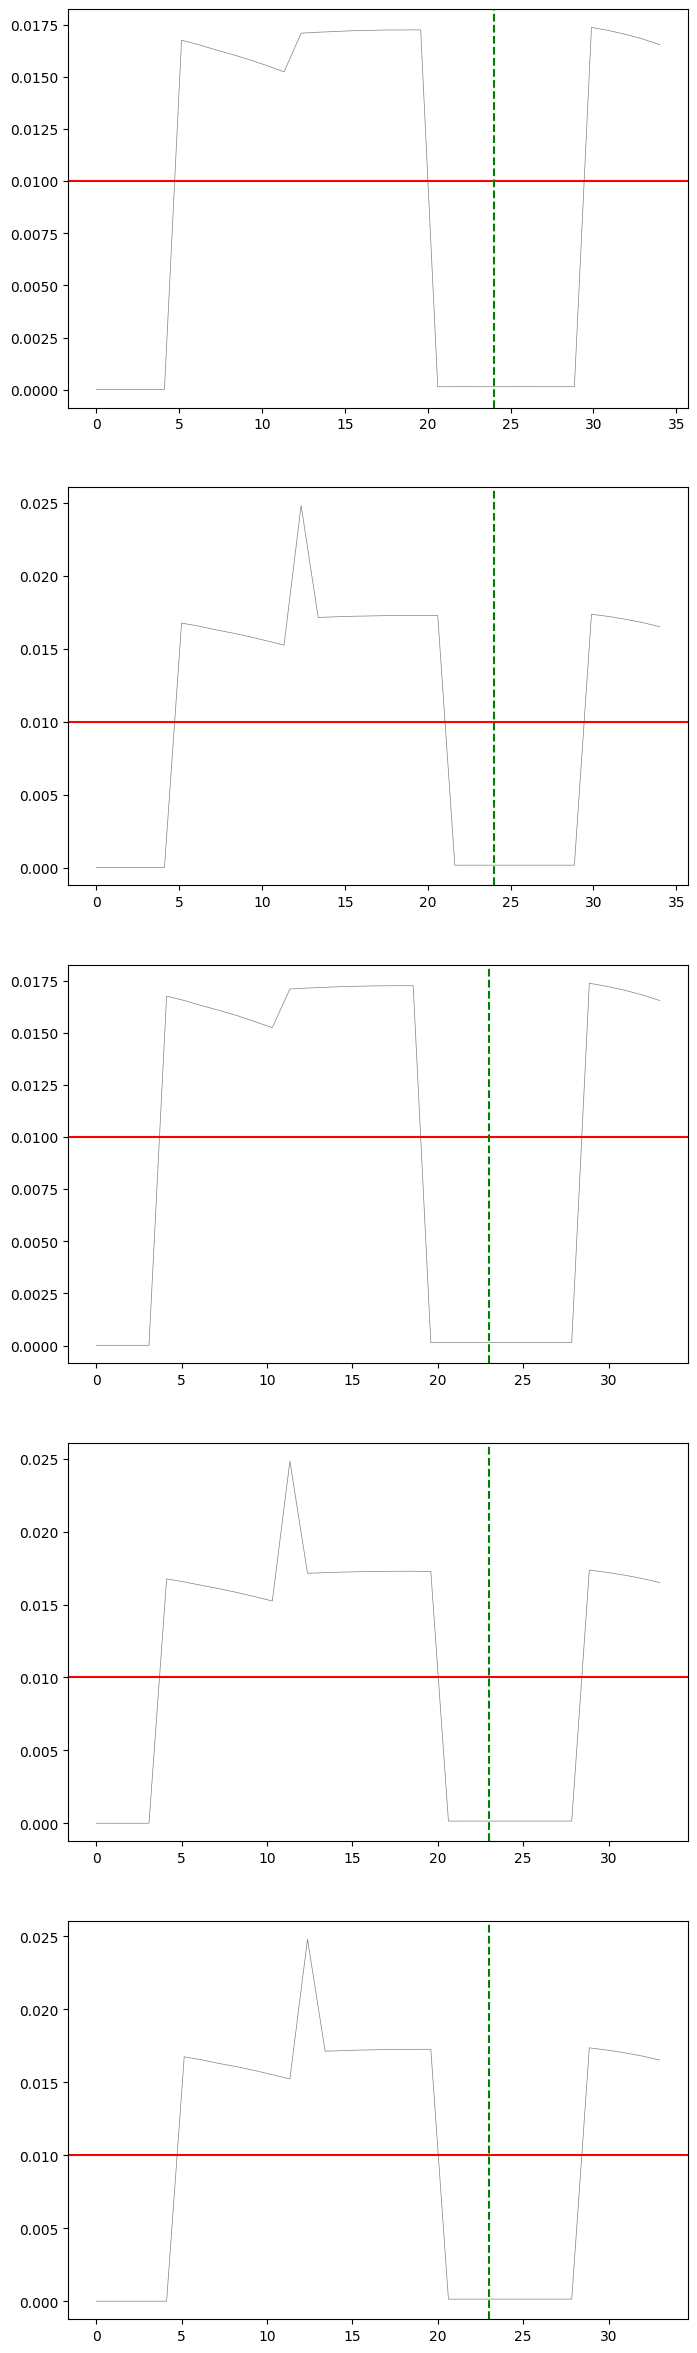

2025-04-29 11:45:32.813 | INFO     |  Creating segement of demos.
2025-04-29 11:45:32.820 | INFO     |  Subsampling to length 32 using strategy mean-length.
2025-04-29 11:45:32.821 | INFO     |  Creating segement of demos.
2025-04-29 11:45:32.827 | INFO     |  Subsampling to length 19 using strategy mean-length.
2025-04-29 11:45:32.828 | INFO     |  ... created 2 segments
2025-04-29 11:45:32.828 | INFO     |    Fitting candidate frame 1/10
2025-04-29 11:45:32.828 | INFO     |    Creating partial frame view of demos.
2025-04-29 11:45:32.835 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-04-29 11:45:32.835 | INFO     |    Changing number of components to 8
2025-04-29 11:45:32.835 | INFO     |    Model init ...


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:33.042 | INFO     |    Fitting candidate frame 2/10
2025-04-29 11:45:33.043 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:33.267 | INFO     |    Fitting candidate frame 3/10
2025-04-29 11:45:33.267 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:33.476 | INFO     |    Fitting candidate frame 4/10
2025-04-29 11:45:33.477 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:33.699 | INFO     |    Fitting candidate frame 5/10
2025-04-29 11:45:33.699 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:33.921 | INFO     |    Fitting candidate frame 6/10
2025-04-29 11:45:33.922 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:34.118 | INFO     |    Fitting candidate frame 7/10
2025-04-29 11:45:34.119 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:34.350 | INFO     |    Fitting candidate frame 8/10
2025-04-29 11:45:34.351 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:34.632 | INFO     |    Fitting candidate frame 9/10
2025-04-29 11:45:34.632 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:35.001 | INFO     |    Fitting candidate frame 10/10
2025-04-29 11:45:35.002 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 11:45:35.246 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-04-29 11:45:35.247 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-04-29 11:45:35.247 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-04-29 11:45:35.247 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-04-29 11:45:35.248 | INFO     |  Creating partial frame view of demos.
2025-04-29 11:45:35.324 | INFO     |    Fitting candidate frame 1/10
2025-04-29 11:45:35.324 | INFO     |    Creating partial frame view of demos.
2025-04

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:35.406 | INFO     |    Fitting candidate frame 2/10
2025-04-29 11:45:35.406 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:35.497 | INFO     |    Fitting candidate frame 3/10
2025-04-29 11:45:35.498 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:35.630 | INFO     |    Fitting candidate frame 4/10
2025-04-29 11:45:35.630 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:35.772 | INFO     |    Fitting candidate frame 5/10
2025-04-29 11:45:35.773 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:35.895 | INFO     |    Fitting candidate frame 6/10
2025-04-29 11:45:35.896 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:35.993 | INFO     |    Fitting candidate frame 7/10
2025-04-29 11:45:35.994 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:36.086 | INFO     |    Fitting candidate frame 8/10
2025-04-29 11:45:36.086 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:36.252 | INFO     |    Fitting candidate frame 9/10
2025-04-29 11:45:36.253 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:36.484 | INFO     |    Fitting candidate frame 10/10
2025-04-29 11:45:36.484 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-29 11:45:36.637 | INFO     |  Creating partial frame view of demos.
2025-04-29 11:45:36.639 | INFO     |  Segmented trajs into 2 segments
2025-04-29 11:45:36.645 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   
Segment 1 -0.142856 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142857 -6.537937e-07 -7.497422e-07 -2.488463e-06  
Segment 1 -0.142857 -3.913916e-07 -2.793745e-07 -8.367642e-07  
2025-04-29 11:45:36.650 | INFO     |  Frame score (rel):
            ee_init  obj000  obj001  obj002  obj003  obj004  obj005    obj006  \
Segment 0  0.999999     1.0     1.0     1.0     1.0     1.0     1.0  0.000005   
Segment 1  0.999993     1.0     1.0     1.0     1.0     1.0     1.0  0.000003   

             obj007    obj008  
Segment 0  0.000005  0.000017  
Segment 1  0.000002 

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-04-29 11:45:36.686 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[1.31e+054, 1.31e+054, 9.09e+053, ..., 6.28e-132, 1.45e-136,
          2.31e-141],
         [1.96e+053, 4.40e+053, 7.52e+053, ..., 2.01e-078, 4.43e-081,
          7.41e-084],
         [1.69e+050, 1.09e+051, 4.85e+051, ..., 3.81e-039, 3.98e-042,
          2.89e-045],
         ...,
         [1.86e+010, 1.69e+012, 1.05e+014, ..., 7.29e+041, 9.68e+039,
          8.83e+037],
         [4.50e-004, 5.77e-002, 5.18e+000, ..., 1.64e+046, 4.19e+044,
          7.47e+042],
         [9.95e-016, 9.12e-015, 7.71e-014, ..., 2.34e+051, 1.75e+051,
          1.21e+051]]),
  array([[2.65e+52, 2.94e+52, 2.68e+52, 2.01e+52, 1.24e+52, 6.31e+51,
          3.09e+50, 1.95e+47, 1.81e+42, 2.94e+35, 5.68e+34, 9.05e+33,
          1.19e+33, 1.28e+32, 1.14e+31, 8.34e+29, 5.03e+28, 2.49e+27,
          1.02e+26, 2.57e+52, 2.89e+52, 2.68e+52, 2.04e+52, 1.28e+52,
          6.63e+51, 3.56e+50, 2.52e+47, 2.69e+42, 5.22e+35, 1.01e+35,
          1.60e+34, 2.09e+33, 2.24e+32, 1.99e+31, 1.45e+30, 8.70e+28,
          4.

In [9]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                        init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,))


2025-04-29 11:45:38.313 | INFO     |  Did not specify time_based, deciding automatically.


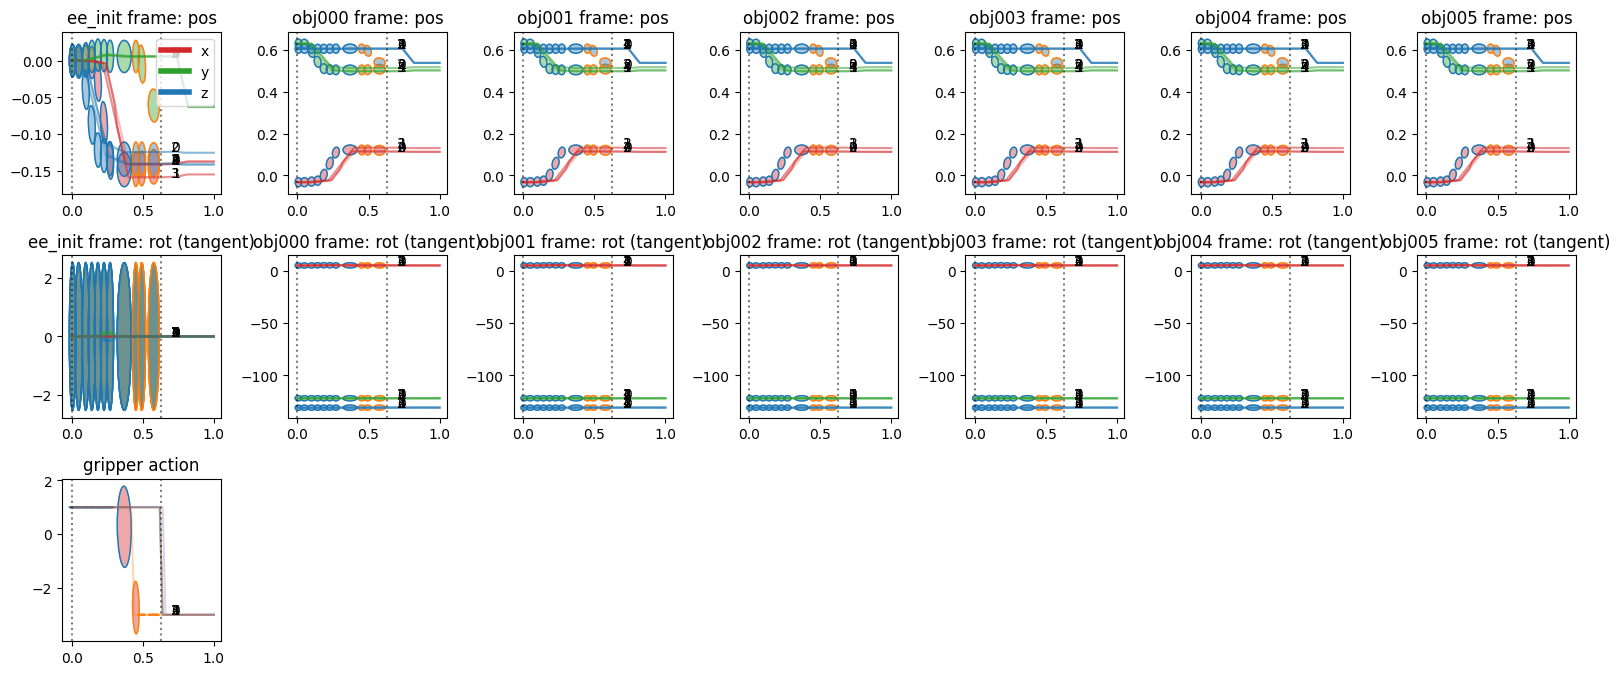

In [10]:
atpgmm.plot_model(
    scatter=True,
    rotations_raw=True,
    plot_traj=True,
    plot_gaussians=True,
    annotate_gaussians=False,
    annotate_trajs=True,
    mean_as_base=False,
    per_segment=False,
    gaussian_mean_only=False,
    plot_traj_means=False,
)  # , size=(150, 10))

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-04-29 11:45:45.308 | INFO     |  Fitting AutoTPGMM
2025-04-29 11:45:45.308 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-04-29 11:45:45.320 | INFO     |  HMM EM ...
2025-04-29 11:45:45.345 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-29 11:45:45.893 | INFO     |  HMM init priors not defined, initializing to uniform
2025-04-29 11:45:49.069 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[8.70e-001, 7.49e-001, 5.46e-001, ..., 2.69e-183, 8.28e-188,
          1.91e-192],
         [1.30e-001, 2.51e-001, 4.51e-001, ..., 8.58e-130, 2.53e-132,
          6.14e-135],
         [1.12e-004, 6.19e-004, 2.91e-003, ..., 1.63e-090, 2.27e-093,
          2.40e-096],
         ...,
         [1.23e-044, 9.61e-043, 6.30e-041, ..., 3.12e-010, 5.53e-012,
          7.31e-014],
         [2.98e-058, 3.29e-056, 3.11e-054, ..., 7.02e-006, 2.39e-007,
          6.19e-009],
         [6.59e-070, 5.20e-069, 4.63e-068, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[2.10e-01, 1.27e-01, 7.36e-02, 4.11e-02, 2.24e-02, 1.20e-02,
          5.22e-04, 9.07e-07, 1.16e-11, 7.82e-19, 1.16e-19, 1.54e-20,
          1.79e-21, 1.84e-22, 1.68e-23, 1.36e-24, 9.67e-26, 6.10e-27,
          3.40e-28, 2.19e-01, 1.34e-01, 7.80e-02, 4.37e-02, 2.39e-02,
          1.28e-02, 6.07e-04, 1.15e-06, 1.86e-11, 1.38e-18, 2.06e-19,
          2.72e-20, 3.17e-21, 3.26e-22, 2.98e-23, 2.40e-24, 1.71e-25,
          1.

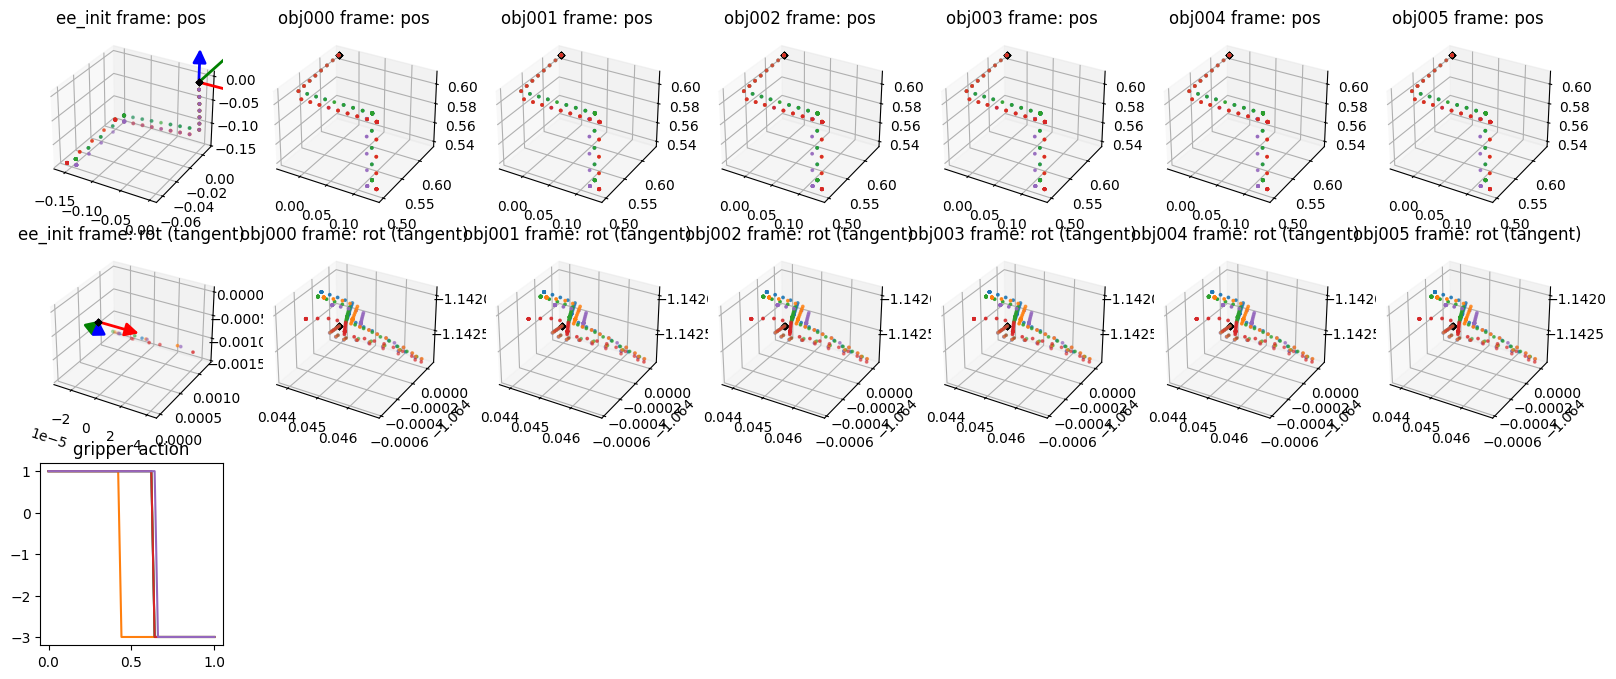

In [12]:
atpgmm.plot_model(
    scatter=True,
    rotations_raw=True,
    plot_traj=True,
    plot_gaussians=False,
    annotate_gaussians=True,
    annotate_trajs=False,
    mean_as_base=False,
    per_segment=False,
    gaussian_mean_only=False,
    plot_traj_means=False,
    time_based=False,
)

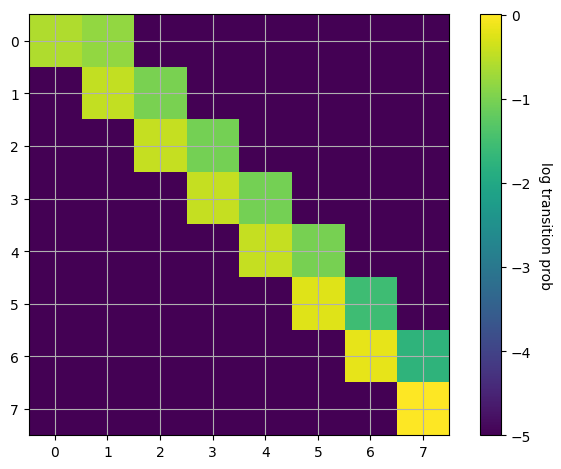

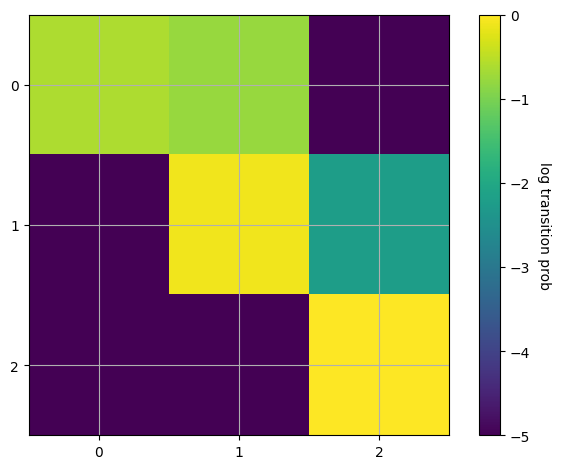

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-04-29 11:45:54.421 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-04-29 11:45:54.598 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-04-29 11:45:54.628 | INFO     |  Caculated segment transition probabilities: (array([[1.]]),)
2025-04-29 11:45:54.628 | INFO     |  Creating partial frame view of demos.
2025-04-29 11:45:54.711 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-29 11:45:55.343 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-29 11:45:56.259 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

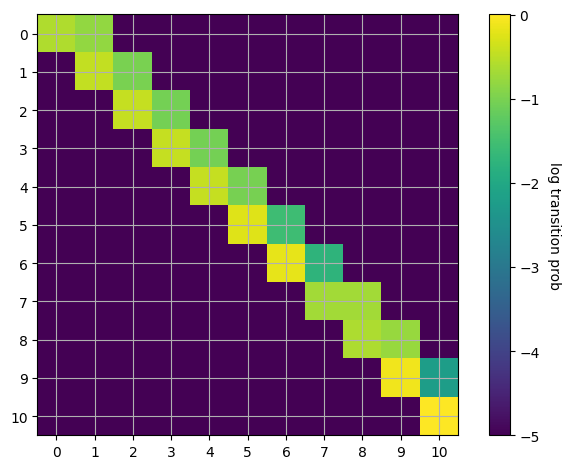

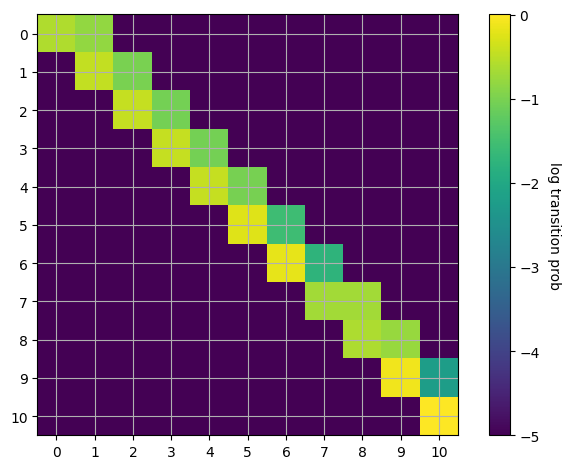

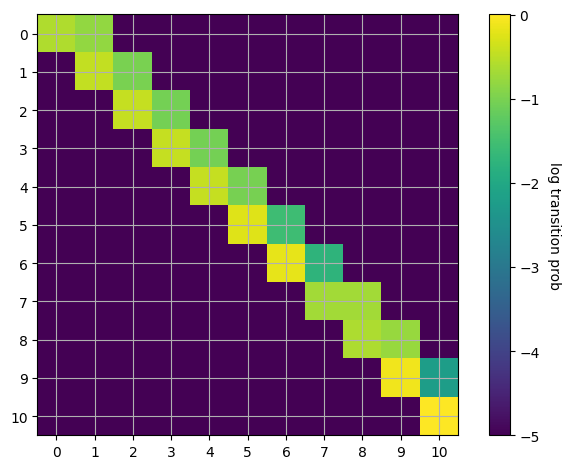

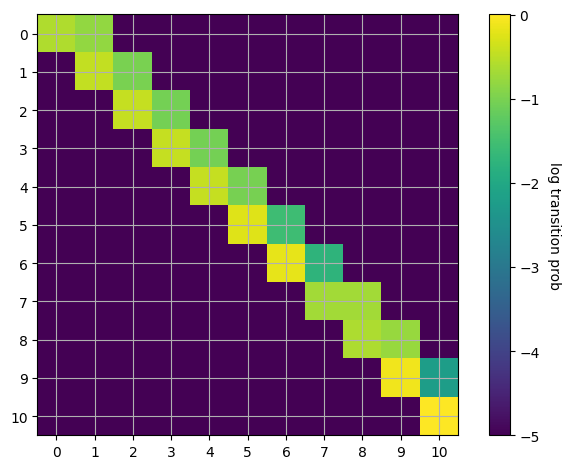

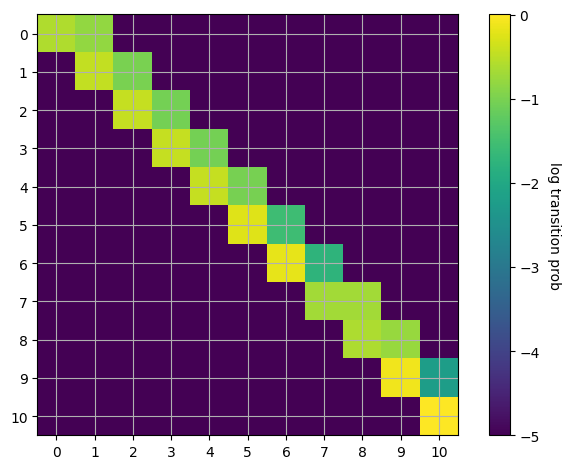

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-04-29 11:45:59.882 | INFO     |  Taking frame origins from demos.


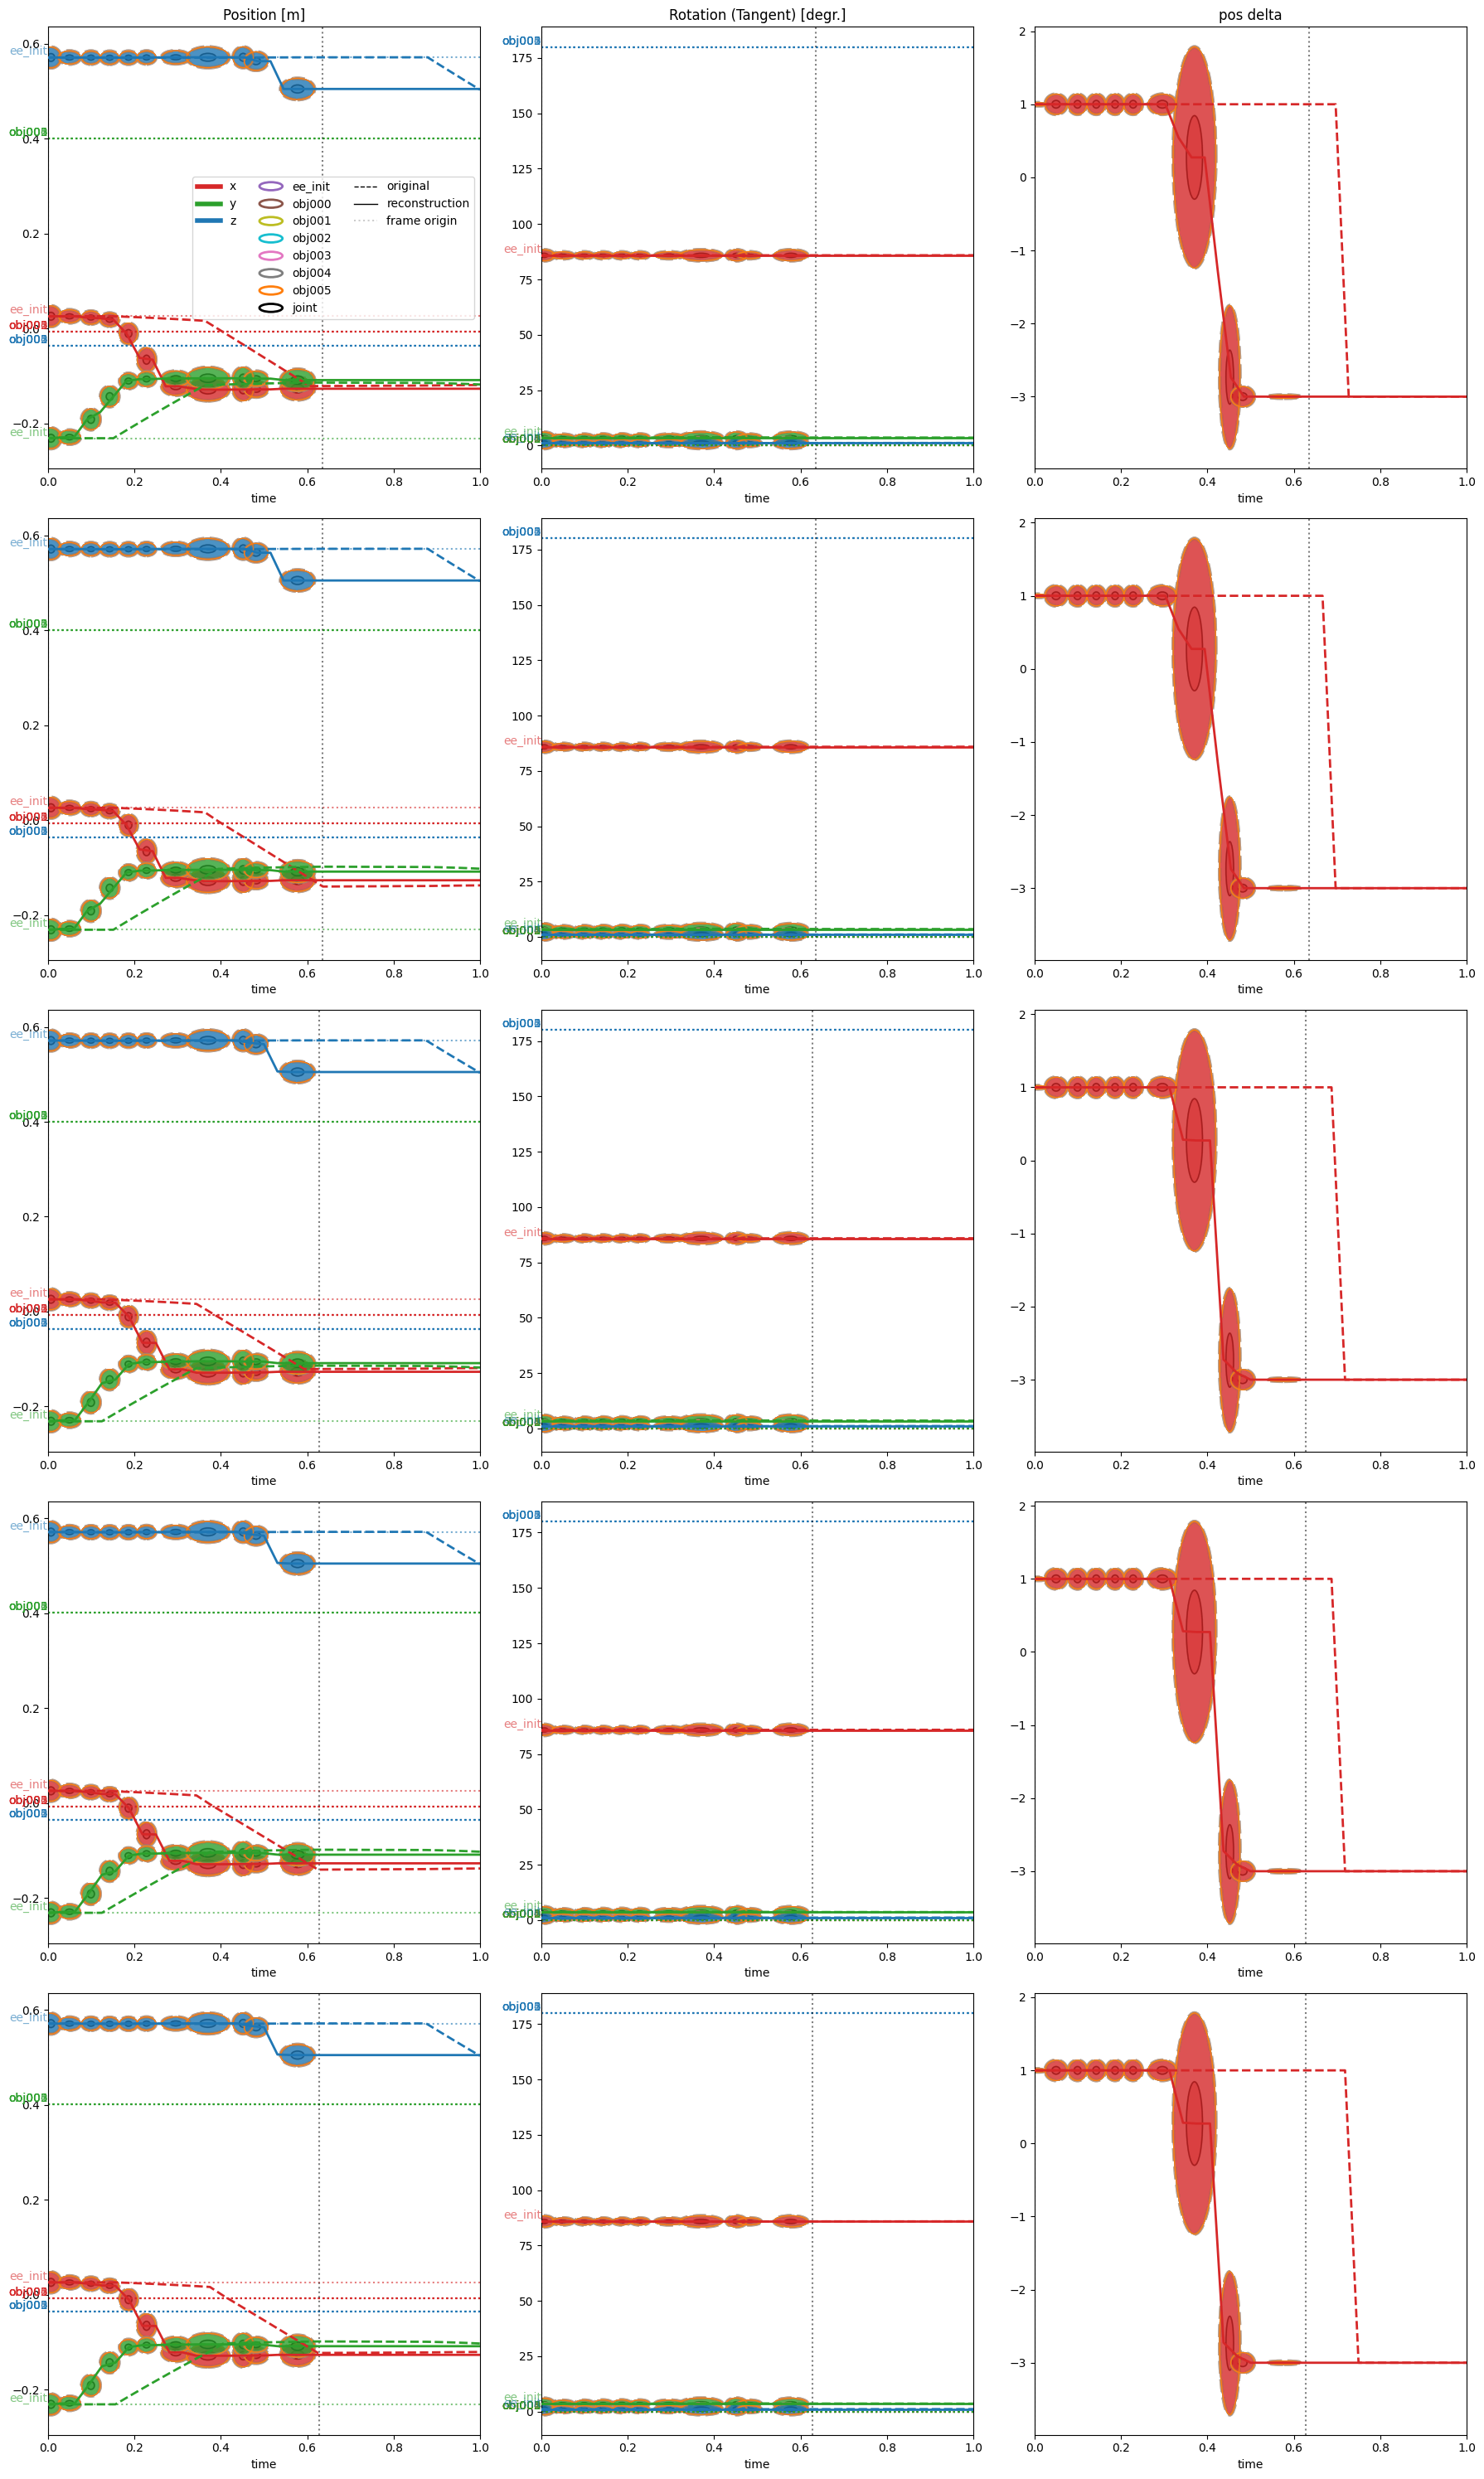

In [17]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

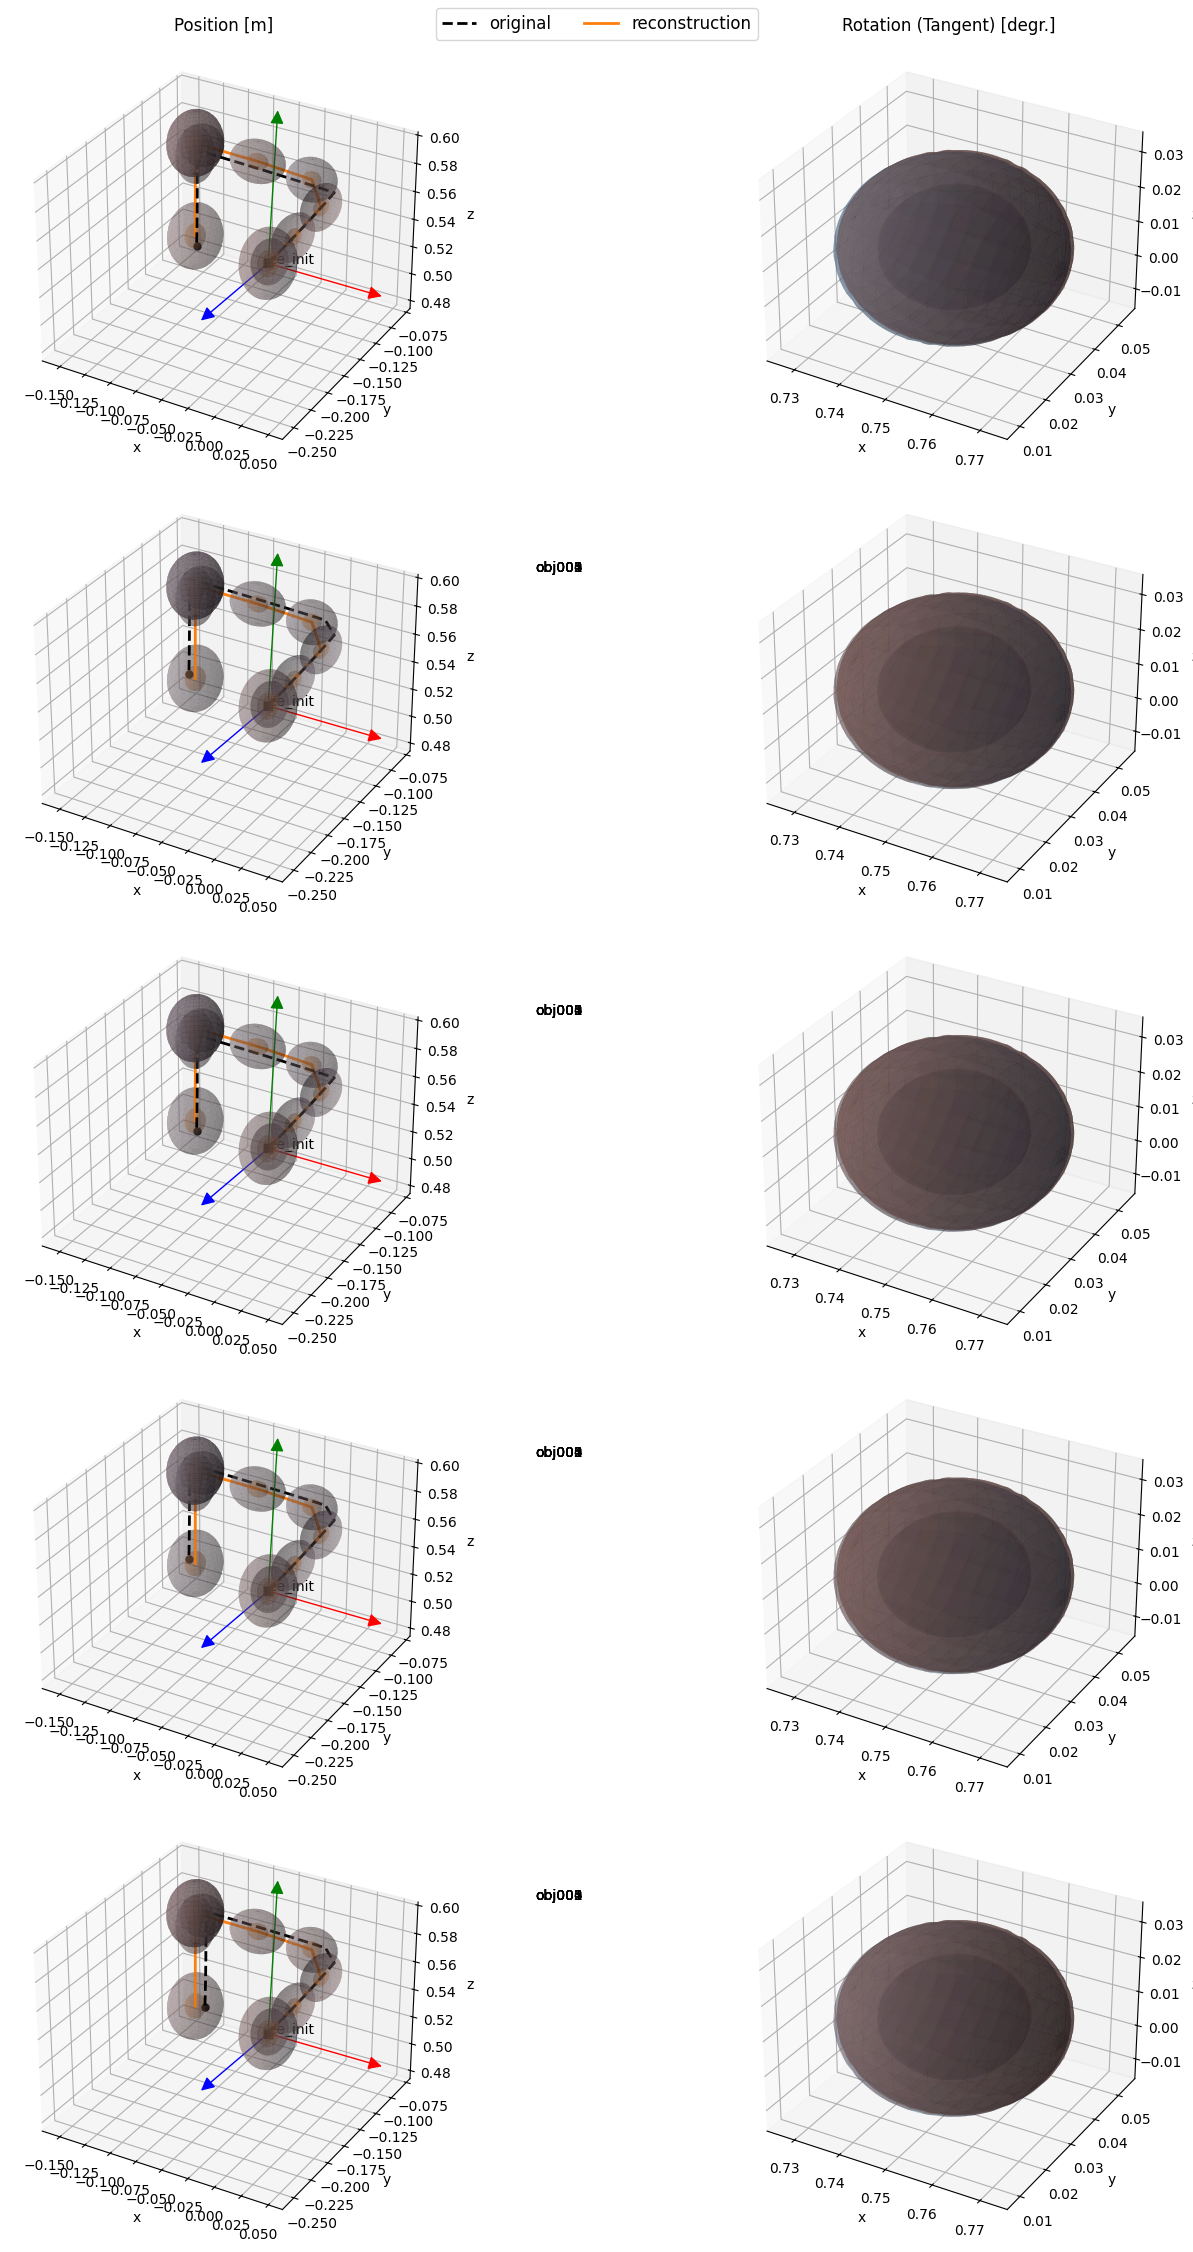

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=False,
    equal_aspect=False,
    per_segment=False,
)